In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
import random
import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from PIL import Image
import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import glob
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
data_dir = pathlib.Path('images/top_10_images')

In [ ]:
artist_df = pd.read_csv('artists.csv')

In [ ]:
# Sort artists by number of paintings
artist_df = artist_df.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artist_df[artist_df['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
batch_size = 32
img_height, img_width = 224, 224
artists_names= sorted(artist_df['name'].str.replace(' ', '_').tolist())

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    seed=123,
    subset='training',
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    seed=123,
    subset='validation', 
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

Found 4299 files belonging to 11 classes.
Using 3440 files for training.
Found 4299 files belonging to 11 classes.
Using 859 files for validation.


In [ ]:
num_classes = 11
input_shape = (batch_size, img_height, img_width, 3)
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"))
model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
model.add(layers.experimental.preprocessing.RandomZoom(0.1))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(512, activation='relu')) 
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                        

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
num_epochs = 50
start_time = time.time()
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=[early_stop]
)
end_time = time.time()
training_time = end_time - start_time

loss, accuracy = model.evaluate(val_ds)
print(f'Validation accuracy: {accuracy}')
print(f'Validation loss: {loss:.4f}')
training_time_minutes = round(training_time / 60, 2)
print(f"Training time: {training_time_minutes} minutes")

Epoch 1/50
108/108 [==============================] - 338s 3s/step - loss: 3.1617 - accuracy: 0.2413 - val_loss: 2.1625 - val_accuracy: 0.3248
Epoch 2/50
108/108 [==============================] - 7s 65ms/step - loss: 2.0520 - accuracy: 0.3259 - val_loss: 2.0162 - val_accuracy: 0.2340
Epoch 3/50
108/108 [==============================] - 8s 66ms/step - loss: 1.9520 - accuracy: 0.3427 - val_loss: 2.4533 - val_accuracy: 0.2596
Epoch 4/50
108/108 [==============================] - 8s 66ms/step - loss: 1.8633 - accuracy: 0.3916 - val_loss: 2.0684 - val_accuracy: 0.3318
Epoch 5/50
108/108 [==============================] - 7s 65ms/step - loss: 1.7886 - accuracy: 0.4235 - val_loss: 2.6525 - val_accuracy: 0.2875
Epoch 6/50
108/108 [==============================] - 8s 66ms/step - loss: 1.7781 - accuracy: 0.4404 - val_loss: 2.2071 - val_accuracy: 0.3166
Epoch 7/50
108/108 [==============================] - 7s 64ms/step - loss: 1.7151 - accuracy: 0.4439 - val_loss: 2.0921 - val_accuracy: 0.3562

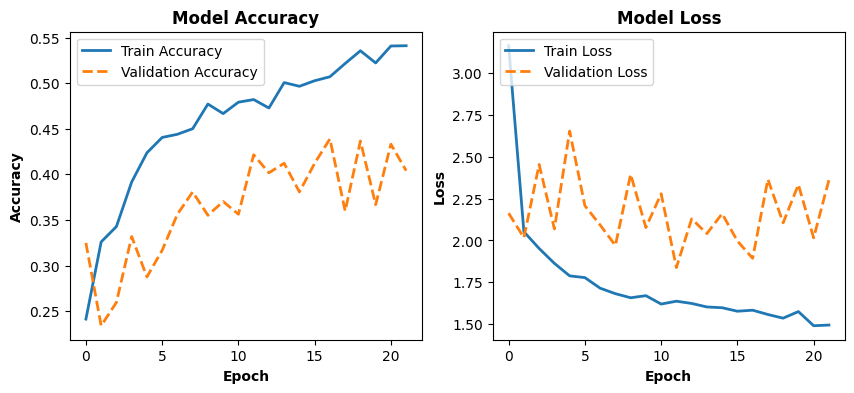

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(model_history.history['accuracy'], linestyle='-', linewidth=2, label='Train Accuracy')
ax1.plot(model_history.history['val_accuracy'], linestyle='--', linewidth=2, label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_xlabel('Epoch', fontweight='bold')
ax1.legend(loc='upper left')
ax2.plot(model_history.history['loss'], linestyle='-', linewidth=2, label='Train Loss')
ax2.plot(model_history.history['val_loss'], linestyle='--', linewidth=2, label='Validation Loss')
ax2.set_title('Model Loss', fontweight='bold')
ax2.set_ylabel('Loss', fontweight='bold')
ax2.set_xlabel('Epoch', fontweight='bold')
ax2.legend(loc='upper left')
plt.show()